In [1]:
#IMPORT DEPENDENCIES
import sys; sys.path.insert(0, 'lib')
import os
import copy
import json
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date

#relative imports of Isotomics
cwd = Path().resolve()
sys.path.insert(1, os.path.join(cwd, 'lib'))
import fragmentAndSimulate as fas
import calcIsotopologues as ci
import readInput as ri
import solveSystem as ss
import basicDeltaOperations as op
import fragmentAndSimulate as fas 
import organizeData
import dataAnalyzerMNIsoX as dA
import dataScreenIsoX as dataScreen
import readCSVAndSimulate as sim
import spectrumVis

In [2]:
#SET PARAMETERS
MOLECULE_INPUT_PATH = "Processed Data/Example Input.csv"
STD_DELTAS = [-30] * 6
SMP_DELTAS = [0] * 6
STD_DELTAS_APPROX = [-30] * 6
ABUNDANCE_THRESHOLD = 0
OMIT_MEASUREMENTS = {'M1':{'full':['17O']}}
FRACTIONATION = False
FRACTIONATION_AMOUNT = 0.05
ERROR_PATH = 'Processed Data/Alanine Experimental Errors.csv'
MN_ERROR = 1
MOLECULAR_AVERAGE_SUBSTITUION = '13C'
MOLECULAR_AVERAGE_ERROR = 1
OUTPUT_FILENAME = 'molecular_model_output.csv'
OUTPUT_ISOTOPOLOGUES_FILE = True

#SPECIFY DETAILS ABOUT THE MEASUREMENT
today = date.today()

#Constants for the runs for processing
ACQUISITION_LENGTH = (5, 15) #Change the time here based on how long it takes isotope val to stabilize.
STANDARD_VAL = -31.13 #d13C value of VAN4
NUMBER_OF_CARBONS = 3
STANDARD_DELTA_VALS = [-20.19,-27.7,-62.47,0,0,0,0,0] #initiate array with values for VANA, or whatever is the standard

#CREATE FOLDERS FOR DATA PROCESSING
#set variables related to where data will be output to
OUTPUT_FOLDER_NAME = 'Test_Data_Output' #name your folder that you want all your data to go into (e.g., the name of your experiment)
PROCESSED_DATA_SUBFOLDER_NAME = 'Processed Data'
FILE_EXTENSION = '.isox' #set the extension to be whatever format your files are in. currently, the code handles .isox files
OUTPUT_TO_CSV = True
CSV_OUTPUT_PATH = 'all_data_output.csv'

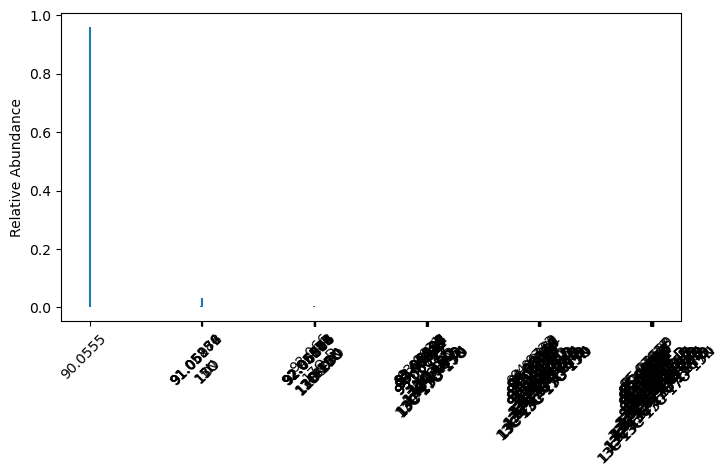

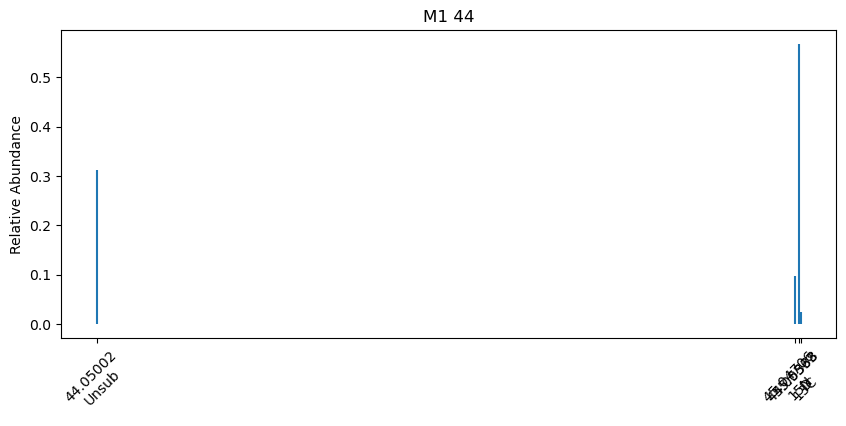

In [3]:
#CONSTRUCT AND EXPLORE SYSTEM
initializedMolecule = sim.moleculeFromCsv(os.path.join(cwd, MOLECULE_INPUT_PATH))
predictedMeasurement, MNDict, fractionationFactors = sim.simulateMeasurement(initializedMolecule, massThreshold = 5)

spectrumVis.fullSpectrumVis(predictedMeasurement['Full Molecule'], initializedMolecule['molecularDataFrame'], figsize = (8,4), massError = 0, lowAbundanceCutOff = 0, xlim = (), ylim = (), outputIsotopologs=OUTPUT_ISOTOPOLOGUES_FILE)
spectrumVis.MNSpectrumVis(initializedMolecule['molecularDataFrame'], '44', predictedMeasurement, 'M1', MNDict, lowAbundanceCutOff = 0, massError = 0, xlim = (), ylim = (), outputIsotopologs=OUTPUT_ISOTOPOLOGUES_FILE)

/Users/sarahzeichner/Documents/GitHub/Isotomics-Automated/lib/solveSystem.py:328: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for sub, v in smp[fragKey].iteritems():
/Users/sarahzeichner/Documents/GitHub/Isotomics-Automated/lib/solveSystem.py:328: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for sub, v in smp[fragKey].iteritems():
/Users/sarahzeichner/Documents/GitHub/Isotomics-Automated/lib/solveSystem.py:328: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for sub, v in smp[fragKey].iteritems():
/Users/sarahzeichner/Documents/GitHub/Isotomics-Automated/lib/solveSystem.py:328: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for sub, v in smp[fragKey].iteritems():
/Users/sarahzeichner/Documents/GitHub/Isotomics-Automated/lib/solveSystem.py:328: FutureWarning: iterite

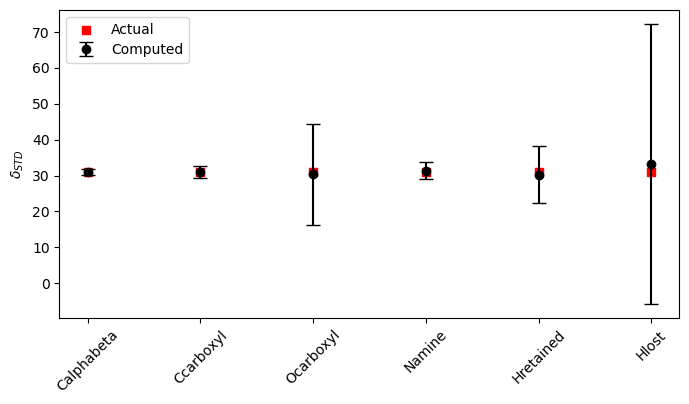

In [4]:
#GET SIMULATION OUTPUT
simulationOutput = sim.simulateSmpStd(os.path.join(cwd, MOLECULE_INPUT_PATH), STD_DELTAS, SMP_DELTAS, STD_DELTAS_APPROX, abundanceThreshold = 0, UValueList = [MOLECULAR_AVERAGE_SUBSTITUION], calcFF = FRACTIONATION, omitMeasurements = OMIT_MEASUREMENTS, ffstd = FRACTIONATION_AMOUNT, errorPath = ERROR_PATH, MNError = MN_ERROR, UValueError = MOLECULAR_AVERAGE_ERROR, resultsFileName = OUTPUT_FILENAME)

In [5]:
#generate nested folders to put your data into
fragmentDictionary = initializedMolecule['fragmentationDictionary'] 
new_folder_path = os.path.join(cwd, PROCESSED_DATA_SUBFOLDER_NAME, OUTPUT_FOLDER_NAME)
folderNames, parent_folder = organizeData.create_nested_folders(fragment_dict=fragmentDictionary.keys(), parent_folder=new_folder_path)

Folder already exists: /Users/sarahzeichner/Documents/GitHub/Isotomics-Automated/Processed Data/Test_Data_Output/full
Folder already exists: /Users/sarahzeichner/Documents/GitHub/Isotomics-Automated/Processed Data/Test_Data_Output/44


In [6]:
#PROCESS DATA FROM FOLDER PATHS
fragmentFolderPaths = organizeData.get_subfolder_paths(parent_folder)
rtnMeans, rtnMergedDict = dA.processIndividualAndAverageIsotopeRatios(fragmentFolderPaths, cwd, outputToCSV=True, csvOutputPath = CSV_OUTPUT_PATH, file_extension = FILE_EXTENSION, processed_data_subfolder=PROCESSED_DATA_SUBFOLDER_NAME, aquisition_length = ACQUISITION_LENGTH)

100%|██████████| 2539/2539 [00:00<00:00, 43450.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


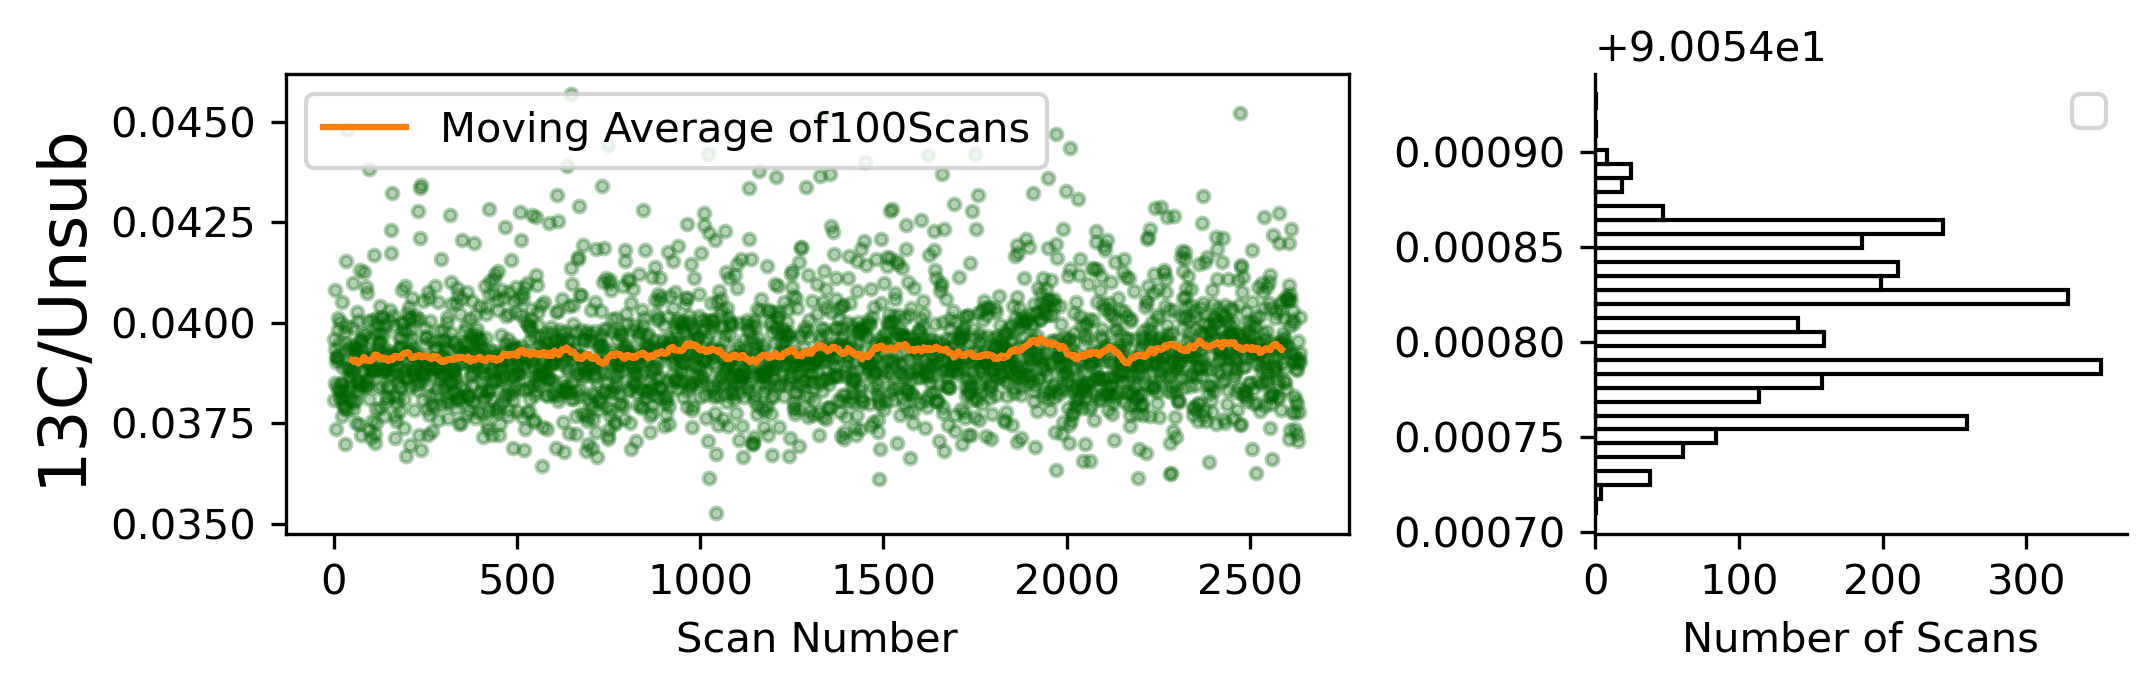

In [7]:
FILEPATH_TO_SCREEN = '/Users/sarahzeichner/Documents/GitHub/Isotomics-Automated/Processed Data/Test_Data_Output/full_molecular_average/Std/20230404_Alanine_MA_Wide.isox'
dataScreen.visualizeTICVersusTime(fileName=FILEPATH_TO_SCREEN, mergedDict=rtnMergedDict, targetRatio='13C/Unsub',scan_averaging_number = 50)

In [47]:
import re 
import numpy as np

def experimentalDataM1(rtnMeans, UValue = '13C/Unsub', UOrbiAndErr = False, processFragKeys = {'44':'44','full_relative_abundance':'full'}):
    #GET FORWARD MODEL STANDARD
    initializedMolecule = sim.moleculeFromCsv(os.path.join(cwd, MOLECULE_INPUT_PATH), deltas = [0] * 6)
    predictedMeasurement, MNDict, fractionationFactors = sim.simulateMeasurement(initializedMolecule, massThreshold = 5)

    #GET U VALUE
    UOrbi, Uerr = getUVal(rtnMeans, initializedMolecule, UValue = UValue, UOrbiAndErr = UOrbiAndErr)

    #GET M+1 DATA
    preparedData = organizeData.prepareDataForM1(rtnMeans)
    replicateData = ri.readObservedData(preparedData, theory = predictedMeasurement,
                                                    standard = [True, False],
                                                    processFragKeys = processFragKeys)
    
    processStandard = replicateData['Std']
    processSample = replicateData['Smp']
    UValuesSmp = {'13C':{'Observed': UOrbi, 'Error': UOrbi *thisURelativeErr}}

    #Generate observed abundance ('O') correction factors
    OValueCorrection = ss.OValueCorrectTheoretical(predictedMeasurement,
                                                processSample,
                                                massThreshold = 1)

    isotopologuesDict = fas.isotopologueDataFrame(MNDict, mDf)

    #Run the M+1 algorithm and process the results
    M1Results = ss.M1MonteCarlo(processStandard, processSample, OValueCorrection, isotopologuesDict, initializedMolecule['fragmentationDictionary'],  N = 100,perturbTheoryOAmt = 0.0003, disableProgress = False)
    processedResults = ss.processM1MCResults(M1Results, UValuesSmp,isotopologuesDict, mDf, UMNSub = ['13C'],disableProgress = True)

    mDf = ss.updateSiteSpecificDfM1MC(processedResults, mDf)
    #END M1 ALGORITHM

def getUVal(rtnMeans, initializedMolecule, UValue = '13C/Unsub', UOrbiAndErr = False):
    '''
    
    '''
    #Optionally pass a tuple, in which case return it directly
    if UOrbiAndErr:
        return UOrbiAndErr[0], UOrbiAndErr[1]
    
    #Various representations of U_VAL; rare_sub gives '13C', U_ValID gives 'C'
    rare_sub = UValue.split('/')[0]
    U_ValID = re.sub(r'\d+', '', rare_sub)

    #Filter by the U Value of interest and perform a sample standard comparison.
    MAData = rtnMeans[rtnMeans['Fragment'] == 'full_molecular_average']
    filtered_data = MAData[MAData['IsotopeRatio'] == UValue]
    grouped = filtered_data.groupby('File Type')[['Average', 'RelStdError']].first()
    thisUVal = 1000 * (grouped.loc['Smp', 'Average'] / grouped.loc['Std', 'Average'] - 1)
    thisURelativeErr = np.sqrt((grouped.loc['Smp', 'RelStdError'])**2 + (grouped.loc['Std', 'RelStdError'])**2)

    #Convert the delta value to concentration, multiply by 3 to go from R to U value
    mDf = initializedMolecule['molecularDataFrame']
    nAtomsThisU = mDf[mDf['IDS'] == U_ValID]['Number'].sum()
    UOrbi = op.concentrationToM1Ratio(op.deltaToConcentration(U_ValID,thisUVal)) * nAtomsThisU

    return UOrbi, thisURelativeErr